
# Advanced Image Processing (TM11005)

*Week 3: Machine learning and Pattern Recognition
Exercise from Lecture 4: CNNs and Unet for image segmentation

@author: Jose Castillo


In this exercise, you will learn how to:
   - Prepare your data to be used with a deep learning model.  
   - Write code to build a unet using the deep learning package Keras.
   - Feed data to a deep network as unet and train it.
   - Supervise the learning of the network and how to quantify it.  

## **Handing in your answers**
For each exercise, you have to hand in answers to questions, and
for some also the code. Hence please only hand in two files in total
for this exercise set:

- Code.py (or .docx): a Python script / Text file containing all the code you are requested to hand in.
- Answers.docx (or .PDF): a text file with the answers to the
questions (plots, text, ...).


## Instruction:
READ CAREFULLY THE FULL COLAB NOTEBOOK AS YOU MOVE FORWARD,
IT IS IMPORTANT TO UNDERSTAND ALL THE STEPS, IF YOU ARE IN DOUBT DO NOT 
HESITATE  ASKING TO ONE OF THE TUTORS. 

# Exercise description:

Colab allows you to use a GPU for your computations , which is required for
Neural network models.

For this exercise we will use part of a public data set named PROSTATEX, 
this data set was used in a challange to classify prostate cancer tumor according to their  gleasons grade. However, for our learning purposes, we will use it
to train a network that will learn how to do automatic prostate segmentation.

If you want to know more details about this data set you can consult the 
following link 

https://wiki.cancerimagingarchive.net/display/Public/SPIE-AAPM-NCI+PROSTATEx+Challenges

## Description: 

The PROSTATEx Challenge ("SPIE-AAPM-NCI Prostate MR Classification Challenge”) 
focused on quantitative image analysis methods for the diagnostic classification 
of clinically significant prostate cancers and was held in conjunction with the 
2017 SPIE Medical Imaging Symposium (see http://www.spie.org/PROSTATEx/).  PROSTATEx 
ran from November 21, 2016 to January 15, 2017, though a "live" version has also 
been established at https://prostatex.grand-challenge.org which serves as an ongoing
 way for researchers to benchmark their performance for this task.   



## !!!!!!!!!!FIRST OF ALL !!!!!!!
    note: opening the console command migh be different for macbooks
     YOU MUST DO THE FOLLOWING:
     1)open the developer console console(Chrome and firefox) by pressing       
      for windows (ctrl + shift + i) | mac (Cmd + Option + J)  and look for the console tab
     2) copy  this:  'allow pasting' (include apostrophes), paste it  in the console and press enter
     3) copy and paste the following , then press enter:
       function ClickConnect(){console.log("Working"); document.querySelector "colab-toolbar-button#connect").click()}setInterval(ClickConnect,60000) 
    
    This last command is to avoid to be disconnected from colab 



## Install SimpleITK and donwload the data


In [1]:

# we install the packages needed for this practical 
!pip install SimpleITK

# We copy the data from a github repository. After runing this command, you will
# inside the tab on your left that some scripst and a folder named "processed". 
# This folder contains the image data set organized by patient folder.
! git clone https://github.com/josemanuel097/Unet_AIP.git


""" Run this part only once.
"""

     |████████████████████████████████| 47.4MB 66kB/s 
Cloning into 'Unet_AIP'...
remote: Enumerating objects: 1213, done.
remote: Counting objects: 100% (1213/1213), done.
remote: Compressing objects: 100% (689/689), done.
remote: Total 1213 (delta 530), reused 1172 (delta 524), pack-reused 0
Receiving objects: 100% (1213/1213), 58.32 MiB | 17.91 MiB/s, done.
Resolving deltas: 100% (530/530), done.


' Run this part only once.\n'

Import the following packages

In [42]:


"""Import neccesary  packages for  the  exercise.
"""

import glob
import os
import numpy as np
from sklearn.model_selection import ShuffleSplit
import SimpleITK as sitk
import matplotlib.pyplot as plt

# Exercise 1 : Getting to Know your data

   Let's get a feeling of the data first. If you check the patient's folder
   you will find two folders; images and their corresponding segmentation.
   Each image correspond to a 2D prostate axial slice.

- Use the SimpleITK package to load a prostate slice from any 
   patient and the segmentation belonging to that slice, preferably choose
   for one of the slices of the middle section,for instance: if the 
   prostate has 14 slices, load slice 7 or one close to it. 
- Plot a figure with a size of 1x3 showing 3 following images:
   - The t2 sequence 
   - The mask 
   - The segmentation overlay on the t2 / The segmentation contour (your choice)
   - Hint: To show the overlay you may use any function learned during previou exercises. As suggestion , you may choose one of these atributes: pyplot.contour or modifying the color map argument from gray to plt.cm.viridis. 

['/content/Unet_AIP/processed//ProstateX-0100/images/Px_ProstateX-0100_slice_11.nii', '/content/Unet_AIP/processed//ProstateX-0100/images/Px_ProstateX-0100_slice_6.nii', '/content/Unet_AIP/processed//ProstateX-0100/images/Px_ProstateX-0100_slice_13.nii', '/content/Unet_AIP/processed//ProstateX-0100/images/Px_ProstateX-0100_slice_5.nii', '/content/Unet_AIP/processed//ProstateX-0100/images/Px_ProstateX-0100_slice_7.nii', '/content/Unet_AIP/processed//ProstateX-0100/images/Px_ProstateX-0100_slice_4.nii', '/content/Unet_AIP/processed//ProstateX-0100/images/Px_ProstateX-0100_slice_15.nii', '/content/Unet_AIP/processed//ProstateX-0100/images/Px_ProstateX-0100_slice_8.nii', '/content/Unet_AIP/processed//ProstateX-0100/images/Px_ProstateX-0100_slice_16.nii', '/content/Unet_AIP/processed//ProstateX-0100/images/Px_ProstateX-0100_slice_10.nii', '/content/Unet_AIP/processed//ProstateX-0100/images/Px_ProstateX-0100_slice_12.nii', '/content/Unet_AIP/processed//ProstateX-0100/images/Px_ProstateX-0100

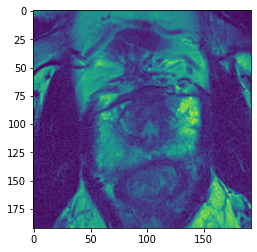

In [3]:

"""Excercise 1  Getting to know the data"""
 # 
# First we define our patient (px) data folder
px       = 'ProstateX-0100'
px_fol   = '/content/Unet_AIP/processed/' 


# We define two variables to save the image and segmentation path.
# As you can see , glob list from a specific directory (px_fol) ,
# for a specific patient (px) , all the files (*) that ends as nifti format (nii.)
img_path = glob.glob(px_fol + '/'+px+'/images/*.nii')
seg_path = glob.glob(px_fol + '/'+px+'/segmentations/*.nii')

"""Check what contains the two variables: img_path and seg_path
"""
print(img_path)
print(img_path[1])
original_image=sitk.ReadImage("/content/Unet_AIP/processed/ProstateX-0000/images/Px_ProstateX-0000_slice_7.nii")

plt.figure
plt.imshow(np.reshape(original_image,[192,192]))


## Tutorial : improving how you load your data:

   You may have noticed that the data is structured in a specific way. This last 
was done  not only with the objective to keep the data organized, but also to 
make the data proccessing with python easier. On the following example
you will see how to get advantage of the directory names to locate the images
for patient 100. In this case we are going to use the python module called 
"glob", Run the following lines, and understand what  the code is doing. 

In [ ]:
   

# 
# First we define our patient (px) data folder
px       = 'ProstateX-0100'
px_fol   = '/content/Unet_AIP/processed/' 


# We define two variables to save the image and segmentation path.
# As you can see , glob list from a specific directory (px_fol) ,
# for a specific patient (px) , all the files (*) that ends as nifti format (nii.)
img_path = glob.glob(px_fol + '/'+px+'/images/*.nii')
seg_path = glob.glob(px_fol + '/'+px+'/segmentations/*.nii')

"""Check what contains the two variables: img_path and seg_path
"""
print(img_path)
print(seg_path)

['/content/Unet_AIP/processed//ProstateX-0100/images/Px_ProstateX-0100_slice_6.nii', '/content/Unet_AIP/processed//ProstateX-0100/images/Px_ProstateX-0100_slice_14.nii', '/content/Unet_AIP/processed//ProstateX-0100/images/Px_ProstateX-0100_slice_2.nii', '/content/Unet_AIP/processed//ProstateX-0100/images/Px_ProstateX-0100_slice_10.nii', '/content/Unet_AIP/processed//ProstateX-0100/images/Px_ProstateX-0100_slice_5.nii', '/content/Unet_AIP/processed//ProstateX-0100/images/Px_ProstateX-0100_slice_7.nii', '/content/Unet_AIP/processed//ProstateX-0100/images/Px_ProstateX-0100_slice_9.nii', '/content/Unet_AIP/processed//ProstateX-0100/images/Px_ProstateX-0100_slice_12.nii', '/content/Unet_AIP/processed//ProstateX-0100/images/Px_ProstateX-0100_slice_11.nii', '/content/Unet_AIP/processed//ProstateX-0100/images/Px_ProstateX-0100_slice_3.nii', '/content/Unet_AIP/processed//ProstateX-0100/images/Px_ProstateX-0100_slice_15.nii', '/content/Unet_AIP/processed//ProstateX-0100/images/Px_ProstateX-0100_

# Exercise 2  :  create patient_path_list function: 
  -  Write a function called create_px_path that takes a list of patients as input.
  -The function should return  two lists. One list should contain the path
    to the images and the other the paths to the segmentation files.
  - IMPORTANT: check that the ordering inside the two list corresponds to the same image and segmentation. For instance, if the first element in the images list corresponds to patient 100 slice 8. Then,the first element of the segmentation list should correspond to patient 100, slice 8 as well. 

In [13]:
"Exercise 2" 
def create_px_path(px_list):
  imag_path=[]
  imag_seg_path=[]

  for px in px_list:
    img_path = glob.glob(px_fol + '/'+px+'/images/*.nii')
    seg_path = glob.glob(px_fol + '/'+px+'/segmentations/*.nii')

    imag_path+=sorted(img_path)
    imag_seg_path+=sorted(seg_path)
    

  return imag_path, imag_seg_path

## Check-point 

Run the following code to check the result of Exercise 2 

In [14]:

"""Check-POINT if you did the previous exercise correctly , this function should't give an error. IF you do get an error, you must go back and fix your code"""

def check_fun(x_path):
    
    samp_lis , _= create_px_path(x_path)
   # print(samp_lis)
    if not samp_lis:
        raise('your create_px_path function is returning an empty list') 

    for sam in samp_lis:
        print(sam)    
        if isinstance(sam,list):
           raise('The output of your create_px_path function is wrong, it returns as output a list with more lists inside...')
    return
 

check_fun(os.listdir(px_fol))

/content/Unet_AIP/processed//ProstateX-0086/images/Px_ProstateX-0086_slice_10.nii
/content/Unet_AIP/processed//ProstateX-0086/images/Px_ProstateX-0086_slice_11.nii
/content/Unet_AIP/processed//ProstateX-0086/images/Px_ProstateX-0086_slice_12.nii
/content/Unet_AIP/processed//ProstateX-0086/images/Px_ProstateX-0086_slice_13.nii
/content/Unet_AIP/processed//ProstateX-0086/images/Px_ProstateX-0086_slice_14.nii
/content/Unet_AIP/processed//ProstateX-0086/images/Px_ProstateX-0086_slice_15.nii
/content/Unet_AIP/processed//ProstateX-0086/images/Px_ProstateX-0086_slice_4.nii
/content/Unet_AIP/processed//ProstateX-0086/images/Px_ProstateX-0086_slice_5.nii
/content/Unet_AIP/processed//ProstateX-0086/images/Px_ProstateX-0086_slice_6.nii
/content/Unet_AIP/processed//ProstateX-0086/images/Px_ProstateX-0086_slice_7.nii
/content/Unet_AIP/processed//ProstateX-0086/images/Px_ProstateX-0086_slice_8.nii
/content/Unet_AIP/processed//ProstateX-0086/images/Px_ProstateX-0086_slice_9.nii
/content/Unet_AIP/proc

# Exercise 3 data Normalization:
In order to reduce the data differences, let's perform a data normalization    using the following formula: 

         norm_imag = image - percentile_05 / (percentile_95 - percentile_5)

- Define a percentile_norm function that takes an image array as
     input and return the image data normalized using the previous formula.
     The goal here is to set all the images intensities in the same range from
     (0 to 1). 
     HINT
     Read the np.percentile function documentation to know how to obtain the 90th
     and 10th percentile with numpy.

  -To check that your function is working properly, plot a 2x3 figure, the first row should contain 3 random prostate slices, the second row will      contain the sames images after being normalized. 
-Even the images intensities where modified in terms of their range, you shall see that they visually are still the same.
     
     Foundation: 
     - The idea behind normalizing the data is related to the fact that a learning
       algorithm (Unet in our case), will use the image intensities to create kernels 
       with features to learn the segmentation. If there are many differences between
       images intensities, finding common kernels for all the images would be a 
       intensive task because the feature space will be too broad. Resulting in a long
       learning process and decreasing the chances of reaching a global minimum.

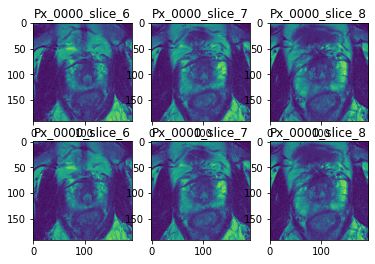

In [47]:

def percentile_norm(image_array)-> np.array:
  np.random.seed(180)   #Do not modify this line , it is for reproducibility.
  norm_image = image_array - (np.percentile(image_array,0.5)/(np.percentile(image_array,95)-np.percentile(image_array,5)))
  return norm_image

%matplotlib inline
fig, axs = plt.subplots(2,3)
# axs[0, 0].plot(x, y)
# axs[0, 0].set_title('Axis [0, 0]')
# axs[0, 1].plot(x, y, 'tab:orange')
# axs[0, 1].set_title('Axis [0, 1]')
# axs[1, 0].plot(x, -y, 'tab:green')
# axs[1, 0].set_title('Axis [1, 0]')
# axs[1, 1].plot(x, -y, 'tab:red')
# axs[1, 1].set_title('Axis [1, 1]')

for i in range(3):

  original_image=sitk.ReadImage(f"/content/Unet_AIP/processed/ProstateX-0000/images/Px_ProstateX-0000_slice_{i+6}.nii")
  axs[0,i].imshow(np.reshape(original_image,[192,192]))
  axs[0,i].set_title(f"Px_0000_slice_{i+6}")
  axs[1,i].imshow(np.reshape(percentile_norm(original_image),[192,192]))
  axs[1,i].set_title(f"Px_0000_slice_{i+6}")

plt.show()


## Tutorial: Splitting the data 
  In this part of the code we define a function that split our patient
  data into training, validation and test. The function takes a list of patient
  names and randomly split it. First into training and test, then the training
  is split into training and validation. In each iteration we take 20% of the patient data. The function returns a data dictionary with the names of the patient on each set. 

In [50]:
""" 
"""

def split_data_train_val_test(px_fol):

    patients = os.listdir(px_fol)
    patients = np.asarray(patients)

    ss    = ShuffleSplit(n_splits=1,test_size=0.20)
    ss.get_n_splits(patients)

    for train_index, test_index in ss.split(patients):
        xt, x_test = patients[train_index], patients[test_index]
        
    ss = ShuffleSplit(n_splits=1, test_size=0.20)
    ss.get_n_splits(xt)    
    
    for ten_index, val_index in ss.split(xt):
        x_train_in, x_val_in= xt[ten_index], xt[val_index]       
   
    px_splits = {'train': np.ndarray.tolist(x_train_in),
                 'val'  : np.ndarray.tolist(x_val_in)  ,
                 'test' : np.ndarray.tolist(x_test)    }
    
    return px_splits


""" Lastly we call our function and split the data
"""
px_fol_path = '/content/Unet_AIP/processed/'
px_split_di = split_data_train_val_test(px_fol_path)
print(px_split_di["train"])

['ProstateX-0026', 'ProstateX-0106', 'ProstateX-0098', 'ProstateX-0100', 'ProstateX-0044', 'ProstateX-0078', 'ProstateX-0104', 'ProstateX-0040', 'ProstateX-0035', 'ProstateX-0102', 'ProstateX-0039', 'ProstateX-0042', 'ProstateX-0034', 'ProstateX-0086', 'ProstateX-0082', 'ProstateX-0085', 'ProstateX-0110', 'ProstateX-0081', 'ProstateX-0048', 'ProstateX-0114', 'ProstateX-0092', 'ProstateX-0115', 'ProstateX-0030', 'ProstateX-0090', 'ProstateX-0136']


# Exercise 4:
   While training the network, we will need to provide the patients data paths. 
   Therefore, we need to obtain the path to each patient and their images. 
   
   - Use your create_px_path function from exercise 2 to generate the paths of each set. 
   - You will have to provide an image dictionary per set (x_train/val/test) and a segmentation dictionary (y_train /val /test).
   - We use the x and y as a convention in machine learning for training data (x) and target/label data
   (y).

In [52]:
"""
"""
    

x_train , y_train = create_px_path(px_split_di["train"])
x_valid , y_valid = create_px_path(px_split_di["val"])
x_test  , y_test  = create_px_path(px_split_di["test"])

['/content/Unet_AIP/processed//ProstateX-0112/images/Px_ProstateX-0112_slice_0.nii', '/content/Unet_AIP/processed//ProstateX-0112/images/Px_ProstateX-0112_slice_1.nii', '/content/Unet_AIP/processed//ProstateX-0112/images/Px_ProstateX-0112_slice_10.nii', '/content/Unet_AIP/processed//ProstateX-0112/images/Px_ProstateX-0112_slice_11.nii', '/content/Unet_AIP/processed//ProstateX-0112/images/Px_ProstateX-0112_slice_12.nii', '/content/Unet_AIP/processed//ProstateX-0112/images/Px_ProstateX-0112_slice_13.nii', '/content/Unet_AIP/processed//ProstateX-0112/images/Px_ProstateX-0112_slice_14.nii', '/content/Unet_AIP/processed//ProstateX-0112/images/Px_ProstateX-0112_slice_15.nii', '/content/Unet_AIP/processed//ProstateX-0112/images/Px_ProstateX-0112_slice_2.nii', '/content/Unet_AIP/processed//ProstateX-0112/images/Px_ProstateX-0112_slice_3.nii', '/content/Unet_AIP/processed//ProstateX-0112/images/Px_ProstateX-0112_slice_4.nii', '/content/Unet_AIP/processed//ProstateX-0112/images/Px_ProstateX-0112

##     Tutorial: Batch generator

  These functions allow us to create a batch of data that is going to be
    feeaded to Unet , one for the images and other for the segmentations. The
    only difference is the noramlization for the t2 images, which is not
    required for the segmentation image.

In [53]:
""" DO NOT MODIFY """
def generate_batch_norm(batch):
    data = []
    
    for img in batch:
        #print('img = '+str(img))
        img_data = sitk.ReadImage(img) 
                
        img_data = sitk.GetArrayFromImage(img_data)
        img_data = img_data.astype('float32')
        img_data = percentile_norm(img_data)
        data.append(img_data)

    data = np.stack(data)


    data = np.reshape(data, (data.shape[0],data.shape[2],data.shape[1],1))
    return data
 
def generate_batch(batch):
    data = []
    
    for img in batch:
        #print('img = '+str(img))
        img_data = sitk.ReadImage(img) 
                
        img_data = sitk.GetArrayFromImage(img_data)
        img_data = img_data.astype('float32')
        data.append(img_data)

    data = np.stack(data)


    data = np.reshape(data, (data.shape[0],data.shape[2],data.shape[1],1))
    return data   


  ## Tutorial Data Generator
Example Data generator: This function is made to generate a image batch. Neural networks consume a lot
   of computing resources, therefore to train a network like U-net we feed it with
   smaller portions of data, a data batch. This function takes a list of patient
   image paths , image targets and the desired batch size. As you can see, the
   end of the function finish with the word "yield" instead of return. This means 
   that the local variables will be kept while the condition of the function is
   true, this kind of statement is used to return intermediate results. 
   In other words, we can keep "feeding" the Unet with data continuously, by providing
   data batches until we reach to the end of the image list (while 
   the function is called by the network). 

In [54]:
"""DO NOT MODIFY

""" 
def data_generator(x_lis,y_tar,d_size):
    while True:
        len_lis = len(x_lis)
        nu_part = (len_lis//d_size)+1
        count   = 0
        
        for i in range(nu_part):
        
            if count >= len_lis:
                continue    
            
            if i+1 == d_size:
               p_list = x_lis[count:]
               segment= y_tar[count:]
            else:
               p_list  = x_lis[count:count+d_size]
               segment = y_tar[count:count+d_size]
            
            images = generate_batch_norm(p_list)
            target = generate_batch(segment)
            count += d_size 
            yield images, target  

    
            

 ##  Dice coefficient formula: 
   To compute the error during learning process we will use the dice 
   coefficient. Every time the network performs a prediction (y_pred = segmentation prediction),
   this new predicted image will be compared with the ground truth (y_true). Then, 
   based on this error value, the network will update its parameters in order to improve 
   the prediction for the next time it sees a new example. This process occurs mathematically
   using differential equations. Therefore, we need define the dice function using tensors,
   which allow us to compute the derivatives in python.

In [55]:
"""DO NOT MODIFY
"""
from keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    K.print_tensor(intersection, message="Dice intersection:")
    return -((2. * intersection + K.epsilon()) / (K.sum(y_true_f)
                                                  + K.sum(y_pred_f)
                                                  + K.epsilon()))
    
    
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)    

# Exercise 5  Define Unet using keras:

On this part you will have to complete the code to  define unet. Given that the original unet request many computational resources, we will define a slightly simpler unet. As you can see most of the code is written already, you will need to use the image provided for this practical (unet_model_architecture.png) 
   to complete the code.
  - The parts that specifically requires your imput are marked like this:
   'x,x '.

  - Define the input layer according to your image size and color channels    (height, width, channels)   

  - For the convolution layers  you must define ONLY
     the number of kernels and a kernel  size =  3. The size of input
     and output is taken care by tensorflow and keras.

  - Define the Max pooling layers using a pooling of 2x2

  - For the upsampling layers you will need a kernel size = 2.


  - Notice that the number of kernels is doubled on each convoultional layer
     while the kernel size is kept the same.

  - HINT: you may use keras documentation to help you with the code:
       https://keras.io/layers/convolutional/

  - When the model is finished, run the line create_unet.   

In [64]:
"""   

"""
from keras import Input
from keras.models import Model
from keras.layers import MaxPooling2D, UpSampling2D, Dropout
from keras.optimizers import Adam
from keras.layers import Concatenate, Conv2D
from keras.preprocessing.image import array_to_img
from keras.callbacks import ModelCheckpoint
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()



from keras.utils import plot_model
    
def create_unet():
    '''
    Create a U-Net
    '''
    print('Creating U-Net...')

    # First, we have to provide the dimensions of the input images
    inputs = Input((192, 192,1))

    conv1 = Conv2D(8,3, activation='relu', padding='same',
                   kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(8,3, activation='relu', padding='same',
                   kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)


    print('conv1 shape:', conv1.shape)
    print('pool1 shape:', pool1.shape)

    conv2 = Conv2D(16,3, activation='relu', padding='same',
                   kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(16,3, activation='relu', padding='same',
                   kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    print('conv2 shape:', conv2.shape)
    print('pool2 shape:', pool2.shape)


    conv3 = Conv2D(32,32, activation='relu', padding='same',
                   kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(32,32, activation='relu', padding='same',
                   kernel_initializer='he_normal')(conv3)
    drop4 = Dropout(0.5)(conv3)  # Added
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)


    print('conv3 shape:', conv3.shape)
    print('pool3 shape:', pool3.shape)

    conv4 = Conv2D(64,64, activation='relu', padding='same',
                   kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(64,64, activation='relu', padding='same',
                   kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)

    print('conv4 shape:', conv4.shape)


    up7 = Conv2D(64,2, activation='relu', padding='same',
                 kernel_initializer='he_normal')(
                         UpSampling2D(size=(2, 2))(drop4))  # Changed
    merge7 = Concatenate(axis=3)([conv3, up7])
    conv7 = Conv2D(32,3,activation='relu', padding='same',
                   kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(32,3, activation='relu', padding='same',
                   kernel_initializer='he_normal')(conv7)
    print('conv7 shape:', conv7.shape)

    up8 = Conv2D(32,2, activation='relu', padding='same',
                 kernel_initializer='he_normal')(
                         UpSampling2D(size=(2, 2))(conv7))
    merge8 = Concatenate(axis=3)([conv2, up8])
    conv8 = Conv2D(16,3, activation='relu', padding='same',
                   kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(16,3, activation='relu', padding='same',
                   kernel_initializer='he_normal')(conv8)
    print('conv8 shape:', conv8.shape)

    up9 = Conv2D(16,2, activation='relu', padding='same',
                 kernel_initializer='he_normal')(
                         UpSampling2D(size=(2, 2))(conv8))
    merge9 = Concatenate(axis=3)([conv1, up9])
    conv9 = Conv2D(8,3,activation='relu', padding='same',
                   kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(8,3, activation='relu', padding='same',
                   kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2,3, activation='relu', padding='same',
                   kernel_initializer='he_normal')(conv9)
    print('conv9 shape:', conv9.shape)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    print('conv10 shape:', conv10.shape)

    model = Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer=Adam(lr=1e-4),
                  loss=dice_coef, metrics=[dice_coef_loss])

    

    print('Got U-Net!')

    return model

model = create_unet()

Creating U-Net...
conv1 shape: (?, 192, 192, 8)
pool1 shape: (?, 96, 96, 8)
conv2 shape: (?, 96, 96, 16)
pool2 shape: (?, 48, 48, 16)
conv3 shape: (?, 48, 48, 32)
pool3 shape: (?, 24, 24, 32)
conv4 shape: (?, 24, 24, 64)
conv7 shape: (?, 48, 48, 32)
conv8 shape: (?, 96, 96, 16)
conv9 shape: (?, 192, 192, 2)
conv10 shape: (?, 192, 192, 1)
Got U-Net!


## Tutorial : Training Unet


   In this section we start training Unet. First we define a number of epochs, 
   which is  the number of times that Unet is going to "observe"
   the whole training set, and learn from it the features to perform the segmentation.
   We also define a batch size of 4, which is the number of samples the network
   is going to "see" at the same time. The bigger the number of batches, less
   time will take the network to complete an epoch. However, as the number
   of batches is increased, more RAM is required.


In [65]:




epch = 160
batch_size = 4  




#Here we define where to save the network parameters (weights)
filepath='/content/Unet_AIP/weights_new/w_epoch_.{epoch:02d}_'+'.hdf5'



"""

   To keep track of the learning process we use checkpoints, as you see in the
   code, every 15 epochs we are going to save the parameters of the network(weights).
   Therefore, we can restart the network on a earlier stage to compare the 
   performance with the latest ones. This function is also useful in order
   to make a saving point in case our code fails, you can restart the training from
   one of this checkpoints, so the network doesn't need to start learning
   from the beginning.
   

   IMPORTAN WARNING: WHEN YOU START RUNNING THIS SECTION

   When the model training is finished, we are going to plot the training
   history in the following section. 
"""

#We define our check point based on the dice_coef_loss and check it every 5 epochs
checkpoint = ModelCheckpoint(filepath, monitor='val_dice_coef_loss',period=5, verbose=1, save_best_only=True,
                              mode='max')

callbacks_list = [checkpoint]

"""
   
   Keras package allow us to train the model using the attribute "fit_generator", 
   we give as input the data generator previously defined, we also define what 
   data is going to be used for training and validation. In history we are going
   to save all the training process. 


      Run this part of the code, each epoch should take approximately 3-6 seconds,
   the code will run for 250 epochs. Therefore, you can take this tame to have a
   short coffee brake. After the training is complete, continue with the next
   section. 


"""
  
history=model.fit_generator(data_generator(x_train,y_train, 
                            batch_size),
            steps_per_epoch=len(x_train) // batch_size,
            epochs=epch,
            validation_data=data_generator(x_valid,y_valid,
                                           batch_size),
            validation_steps=len(x_valid) // batch_size,
            callbacks=callbacks_list)   




""" WARNING ....IMPORTANT......WARNING:

    Colab after some minutes of inactivity will erase your session. Therefore,
    all the data, and the weights generated by the network during the training 
    will be removed. To avoid losing your progress, run the code below, this will 
    start  downloading the files obtained during your exercise,
    save them in your local drive.   
"""

import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from google.colab import files
import shutil

pd.to_pickle(history,'/content/Unet_AIP/epochs_history')

files.download('/content/Unet_AIP/epochs_history')
 







/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/160
80/80 [==============================] - ETA: 0s - batch: 39.5000 - size: 7.8000 - loss: -0.3599 - dice_coef_loss: 0.3599

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


80/80 [==============================] - 82s 913ms/step - batch: 39.5000 - size: 7.8000 - loss: -0.3599 - dice_coef_loss: 0.3599 - val_loss: -0.2924 - val_dice_coef_loss: 0.2924
Epoch 2/160
80/80 [==============================] - 15s 189ms/step - batch: 39.5000 - size: 7.8000 - loss: -0.3620 - dice_coef_loss: 0.3620 - val_loss: -0.4055 - val_dice_coef_loss: 0.4055
Epoch 3/160
80/80 [==============================] - 15s 188ms/step - batch: 39.5000 - size: 7.8000 - loss: -0.3654 - dice_coef_loss: 0.3654 - val_loss: -0.4070 - val_dice_coef_loss: 0.4070
Epoch 4/160
80/80 [==============================] - 15s 191ms/step - batch: 39.5000 - size: 7.8000 - loss: -0.3734 - dice_coef_loss: 0.3734 - val_loss: -0.3728 - val_dice_coef_loss: 0.3728
Epoch 5/160
80/80 [==============================] - ETA: 0s - batch: 39.5000 - size: 7.8000 - loss: -0.3595 - dice_coef_loss: 0.3595
Epoch 00005: val_dice_coef_loss improved from -inf to 0.41108, saving model to /content/Unet_AIP/weights_new/w_epoch_.

TypeError: ignored

#   Run these lines: Download your network parameters
   This is just in case you get disconnected from colab
   you can upload you previous results and avoid the 
   full training process.

In [66]:

shutil.make_archive('weights_new', 'zip', '/content/Unet_AIP/weights_new')
files.download('/content/weights_new.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

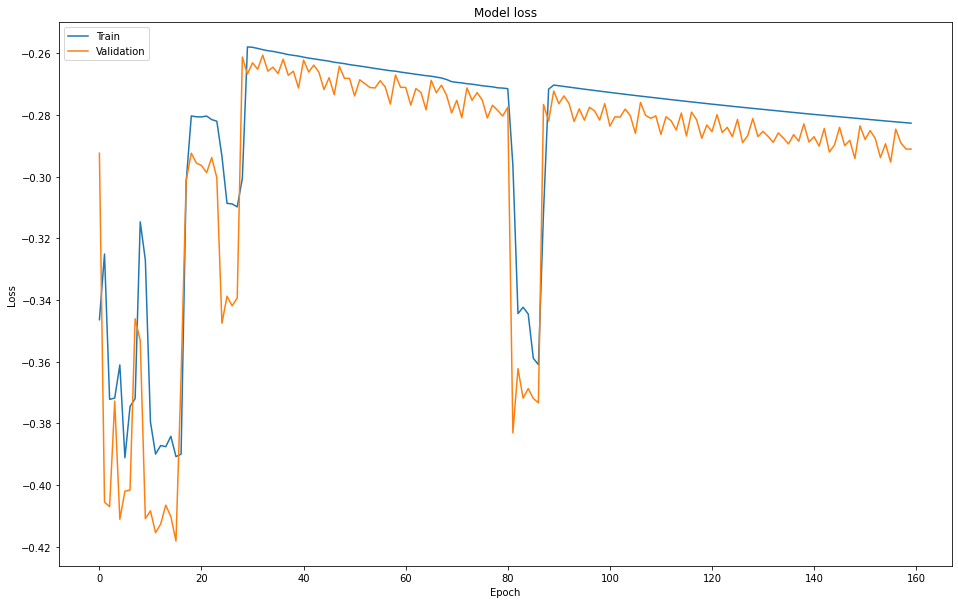

In [67]:
"""
    Plot your loss fuction graph
"""

now = datetime.now()
date_time = now.strftime("%m_%d_%Y_%H:%M:%S")
plt.figure(figsize=(16,10)) 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('/content/Unet_AIP/model_loss_'+str(date_time)+'.png')
plt.show()



In [68]:

""" 
   Download your loss function graph
"""

files.download('/content/Unet_AIP/model_loss_'+str(date_time)+'.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Exercise 6: Explain the Loss Function
Look at the graph, and answer the following

In [ ]:
""" 

    -What is the relationship between the training loss and the validation loss?
    Training loss indicates the performance of the model on data it is also training on. The validation loss measures the model performance on data it "hasn't seen". As the model improves 
    in on training data it should also improve on unseen data(not always the case). 
    
    -How would you use this graph to decide until what point is reasonable to 
     train the network? and why?
     Find the point or plateau where the training loss is minimal for both validation and trainig. This approach is usefull because:
     At minimum training loss the model attains maximum accuracy on the training(good) but this could pair with bad generalization(bad) so also taking into account that the validation
     is at it's minimum makes it so the model performs well on training data(learned enough) and generalizes reasonably(exactly what you want from your model).  

     
"""

## Tutorial: How the model behaves with unseen data.
   
   So far we have an idea how the model will perform with the training and validation
   data. Additionally , we can use the graph to decide which parameters works
   better for our validation data. Nevertheless, in real life situations we do
   not have ground thruth. Therefore, to prove that our estimation is correct
   we need to test our model with data that was not used at all to build our 
   network on the first place. 

   In the following example We will load a patient from the test set, make an
   automatic segmentation with the network and compare the result with the 
   ground truth segmentation. According to out graph we should select a set of 
   weights obtained after epoch 72, from this we could expect a dice coeficent  
   around 0.8. 


In [70]:
"""
"""

# First we load a prostate slice from the test set 

im_arra= generate_batch_norm([x_test[6]])

# Then we  load a set of weights that theoretically will give us a good 
# performance. The weights were save during the training process in the 
# weights_new folder. 

model.load_weights('/content/Unet_AIP/weights_new/weights.150_.hdf5')

# Now that the networks has loaded the weights from the desired epoc, we 
# perfom a prediction on the slice.

mask_pred = model.predict(im_arra)

# The network requires the input to be (1x height x lengh x 1), however
# in order to visualize it , we need to  change it to a 2d array.
mask_pred = mask_pred [0,:,:,0]

# Then we load then ground thruth for that slice.
y_target = sitk.ReadImage(y_test[6])
y_target = sitk.GetArrayFromImage(y_target)


# We define a dice coefficent fuction :

def computeDice(reference, automatic):
    return 2*(np.sum(reference*automatic))/(np.sum(reference)+np.sum(automatic))


# Compute the dice and plot the images to compare
dice=str(computeDice(y_target,mask_pred))
print('dice = '+ str(computeDice(y_target,mask_pred)))  


# Let's visualize the result on the test image
plt.figure(figsize=(16,10))
plt.subplot(1,3,1),plt.imshow(im_arra[0,:,:,0],cmap='gray'),plt.title('Unet_Prediction')
plt.subplot(1,3,1),plt.imshow(mask_pred,cmap=plt.cm.viridis,alpha=.3)

plt.subplot(1,3,2),plt.imshow(im_arra[0,:,:,0],cmap='gray'),plt.title('Ground_truth')
plt.subplot(1,3,2),plt.imshow(y_target,cmap=plt.cm.viridis,alpha=.3)

plt.subplot(1,3,3),plt.imshow(y_target,cmap='gray'),plt.title('Dice = '+dice)
plt.subplot(1,3,3),plt.imshow(mask_pred,cmap=plt.cm.viridis,alpha=.3)


""" As you can see we achieve a "decent" result on one test example. Futhermore,
    small details should be corrected in a post-processing phase. Nevertheless,
    the network has learned some features to manage the segmentation in unseen
    data. 
"""

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


InvalidArgumentError: ignored

 # Exercise 7: Visualize and quantify the learning process
 Select a prostate slice from the test set and make a prediction with the 
  network using 4 sets of weights. 
- Select the weights using the loss function figure as reference, you should select4 weight files that theoretically should increase the performance of the network in increasing order (from the worst to the best).

- Create a figure showing the  network prediction, overlapped on the the original image, including the weights file on the title. 

- Plot te ground truth overlayed on the original image

- At the end your figure size will be 1x5, each plot showing the network prediction on the original image, identified with the weights title.

- Comment your results by answering the following questions:

  -Did the weight selection worked according to your graph? 

  -Can you see the network performance improving during the time?
      
   -Did you get a worse result with the last set of weights? if yes, what     could be the reason behind this?

In [73]:
np.random.seed(6)
"""Code here """
im_arra= generate_batch_norm([x_test[6]])

for index,item in enumerate([110, 170,50, 35]):
  

  # Then we  load a set of weights that theoretically will give us a good 
  # performance. The weights were save during the training process in the 
  # weights_new folder. 

  model.load_weights(f"/content/Unet_AIP/weights_new/w_epoch_.{item}_.hdf5")

  # Now that the networks has loaded the weights from the desired epoc, we 
  # perfom a prediction on the slice.

  mask_pred = model.predict(im_arra)

  # The network requires the input to be (1x height x lengh x 1), however
  # in order to visualize it , we need to  change it to a 2d array.
  mask_pred = mask_pred [0,:,:,0]

  # Then we load then ground thruth for that slice.
  y_target = sitk.ReadImage(y_test[6])
  y_target = sitk.GetArrayFromImage(y_target)

  # Compute the dice and plot the images to compare
  dice=str(computeDice(y_target,mask_pred))
  print('dice = '+ str(computeDice(y_target,mask_pred)))  


  # Let's visualize the result on the test image
  plt.figure(figsize=(16,10))
  plt.subplot(1,5,index),plt.imshow(im_arra[0,:,:,0],cmap='gray'),plt.title('Unet_Prediction')
  plt.subplot(1,5,index),plt.imshow(mask_pred,cmap=plt.cm.viridis,alpha=.3)


plt.subplot(1,5,5),plt.imshow(im_arra[0,:,:,0],cmap='gray'),plt.title('Ground_truth')
plt.subplot(1,5,5),plt.imshow(y_target,cmap=plt.cm.viridis,alpha=.3)









InvalidArgumentError: ignored